In [1]:
from struct import unpack
import numpy as np
import io
from collections import namedtuple
import cv2
from pprint import pprint
import matplotlib.pyplot as plt
import imageio

def psnr(img1, img2):
    try:
        if img1.ndim == img2.ndim:
            nd = img1.ndim
        else:
            raise ValueError("img1 and img2 must have the same number of dimensions")
        return cv2.PSNR(np.copy(img1[:, :, 0:nd]).astype(np.float32), np.copy(img2[:, :, 0:nd]).astype(np.float32))
    except:
        return cv2.PSNR(np.copy(img1).astype(np.float32), np.copy(img2).astype(np.float32))

In [2]:
DEBUG = False

class JPEGError(ValueError): pass

def readFully(fh, length):
    res = fh.read(length)
    if DEBUG:
        print("[readFully]", f"read bits:{res}, length:{len(res)}")
    if len(res) != length:
        raise JPEGError("unexpected EOF")
    return res

def decodeMagnitude(bitstring):
    if bitstring == b'':
        return 0
    val = int(bitstring, 2)
    if DEBUG:
        print("[decodeMagnitude] val:", val)
    if bitstring.startswith(b'0'):
        val += 1 + (-1 << len(bitstring))
    return val

dctA = np.zeros(shape=(8, 8))
for i in range(8):
    c = 0
    if i == 0:
        c = np.sqrt(1 / 8)
    else:
        c = np.sqrt(2 / 8)
    for j in range(8):
        dctA[i, j] = c * np.cos(np.pi * i * (2 * j + 1) / (2 * 8))

zigzag = np.array(
    [[ 0,  1,  5,  6, 14, 15, 27, 28],
    [ 2,  4,  7, 13, 16, 26, 29, 42],
    [ 3,  8, 12, 17, 25, 30, 41, 43],
    [ 9, 11, 18, 24, 31, 40, 44, 53],
    [10, 19, 23, 32, 39, 45, 52, 54],
    [20, 22, 33, 38, 46, 51, 55, 60],
    [21, 34, 37, 47, 50, 56, 59, 61],
    [35, 36, 48, 49, 57, 58, 62, 63]])

def perform_deQuant_and_Idct(coeffs, qtable):
    coeffs_invZig = np.array(coeffs)[zigzag]
    deQuant_coeffs = coeffs_invZig * (qtable.reshape(8, 8))
    if DEBUG:
        print("[coeffs_invZig]")
        pprint(coeffs_invZig)
        print("[qtable]")
        pprint(qtable.reshape(8, 8))
        print("[perform_deQuant]")
        pprint(deQuant_coeffs)
    return cv2.idct(deQuant_coeffs.astype(np.float32))
    # return dctA.T@deQuant_coeffs@dctA

ColorComponent = namedtuple('ColorComponent', 'id hscale vscale qtable'.split())
ScanComponent  = namedtuple('ScanComponent', 'color_cmp dc_entropy ac_entropy'.split())

class EntropyDecoder(object):
    def __init__(self):
        self.table = []

    def add_code(self, code, length, value):
        self.table.append(("{:0{}b}".format(code, length).encode(), value))

    def finalize_codes(self):
        self.table.sort()

    def decode_from(self, bitstream):
        pos = bitstream.tell()
        bcode = bitstream.read(16)
        for tcode, tval in self.table:
            if bcode.startswith(tcode):
                bitstream.seek(pos + len(tcode))
                # print("[decode_from] ##", "({})code={}, ({})value={}".format(type(tcode), tcode, type(tval), tval))
                if DEBUG:
                    print("[decode_from] ##", "code={}, value={}".format(tcode, tval))
                return tval
        raise JPEGError("invalid bitstream - unexpected code")

class JPEG:
    def readLengthDelim(self):
        length = int.from_bytes(readFully(self.fh, 2), byteorder='big')
        if length < 2:
            raise JPEGError("Invalid length")
        return readFully(self.fh, length - 2)

    def __init__(self, image_path, DEBUG=False):
        # with open(image_path, 'rb') as f:
        #     self.fh = f
        self.fh = open(image_path, 'rb')
        self.height, self.width = 0, 0
        self.Quantization_tables = {}
        self.color_components = {}
        self.ac_entropy = {}
        self.dc_entropy = {}
        self.decoded_image = None
        self.DEBUG = DEBUG

    def decode(self):
        while self.decode_one_chunk():
            pass

    def decode_one_chunk(self):
        marker = self.fh.read(2)

        if not marker:
            return False
        if marker[0] != 0xFF:
            raise JPEGError("Not a valid marker: {}".format(marker))
            # print("Not a valid marker: {}".format(marker))
            # unknow = self.readLengthDelim()
            # print("Unknow", unknow)
        if marker[1] == 0xD8:
            print("# [SOI] Start of Image")
        elif marker[1] == 0xE0:
            print("# [App0] Application Default Header")
            self.readLengthDelim()
        elif marker[1] == 0xDB:
            print("# [DQT] Quantization Table")
            dqt = self.readLengthDelim()
            if len(dqt) % 65 != 0:
                raise JPEGError("Invalid DQT length")
            if self.DEBUG:
                print("## DQT length:", len(dqt))
            for i in range(0, len(dqt), 65):
                tbl = dqt[i:i+65]
                if tbl[0] >> 4 != 0:
                    raise JPEGError("Invalid DQT table specifier")
                self.Quantization_tables[tbl[0] & 0x0F] = np.array(list(tbl[1:]))[zigzag]
                # print(np.array(list(tbl[1:])).reshape(8, 8))
            if self.DEBUG:
                for qtb in self.Quantization_tables.items():
                    print(qtb)
        elif marker[1] == 0xC0:
            print("# [SOF] Start of Frame")
            sof = self.readLengthDelim()
            if len(sof) < 6:
                raise JPEGError("Invalid SOF length: SOF too short")
            bits_per_sample = sof[0]
            if bits_per_sample != 8:
                raise JPEGError('only 8 bpp supported')
            self.height = int.from_bytes(sof[1:3], 'big')
            self.width = int.from_bytes(sof[3:5], 'big')
            components = sof[5]
            if self.DEBUG:
                print("## Bits per sample", bits_per_sample)
                print("## Image size:", self.width, "x", self.height)
                print("## Number of Components:", components)
            if len(sof) != 6+sof[5]*3:
                raise JPEGError("SOF wrong length")
            for i in range(components):
                comp = sof[6+3*i:6+3*(i+1)]
                comp_id = comp[0]
                hscale, vscale = comp[1] >> 4, comp[1] & 0x0F
                qt_id = comp[2]
                if {hscale, vscale} - {1, 2}:
                    raise JPEGError("only chroma-halving supported")
                self.color_components[comp_id] = ColorComponent(comp_id, hscale, vscale, self.Quantization_tables[qt_id])
                if self.DEBUG:
                    print("### Component ID: {}, H scaling: {}, V sacling: {}, Quantization table: {}".format(comp_id, hscale, vscale, qt_id))

        elif marker[1] == 0xC4:
            self.DEBUG = True
            print("# [DHT] Huffman Table")
            dht = self.readLengthDelim()
            if len(dht) < 17:
                raise JPEGError("Invalid DHT length: DHT too short")
            
            is_ac = (dht[0] >> 4 ) & 1
            table_id = dht[0] & 0x0F
            if self.DEBUG:
                print("## DC/AC:", "AC" if is_ac else "DC", "Table ID:", table_id)
            
            (self.ac_entropy if is_ac else self.dc_entropy)[table_id] = entropy_dec = EntropyDecoder()
            num_codes_by_length = list(dht[1:17])
            code_ptr = 17
            code_val = 0b0
            for code_len, num_codes in enumerate(num_codes_by_length, 1):
                if num_codes != 0:
                    if self.DEBUG:
                        print("### {} code(s) of length {}".format(num_codes, code_len))
                    for _ in range(num_codes):
                        entropy_dec.add_code(code_val, code_len, dht[code_ptr])
                        if self.DEBUG:
                            print("#### {:0{}b} = {:02x}".format(code_val, code_len, dht[code_ptr]))
                        code_ptr += 1
                        code_val += 1
                code_val <<= 1
            if len(dht) != code_ptr:
                raise JPEGError("DHT wrong length")
            entropy_dec.finalize_codes()

            self.DEBUG = False

        elif marker[1] == 0xDA:
            print("# [SOS] Start of Scan")
            sos = self.readLengthDelim()
            if self.DEBUG:
                print("## SOS length:", len(sos))
            if len(sos) < 4: raise JPEGError("SOS too short")
            if self.DEBUG:
                print("### Number of components:", sos[0])
            if len(sos) != 4 + sos[0]*2: raise JPEGError("SOS wrong length")
            components = []
            for i in range(sos[0]):
                comp = sos[1+2*i:1+2*(i+1)]
                comp_id = comp[0]
                dc_table, ac_table = comp[1] >> 4, comp[1] & 0x0F
                components += [ScanComponent(self.color_components[comp_id], self.dc_entropy[dc_table], self.ac_entropy[ac_table])]
                if self.DEBUG:
                    print("#### Component ID: {}, DC Table: {}, AC Table: {}".format(comp_id, dc_table, ac_table))
            self.decode_entropy_coded(components)
        elif marker[1] == 0xD9:
            print("# [EOI] End of Image")
        return True

    def decode_entropy_coded(self, components):
        mcu_width = max(c.color_cmp.hscale for c in components) * 8
        mcu_height = max(c.color_cmp.vscale for c in components) * 8
        horiz_mcus = (self.width + mcu_width - 1) // mcu_width
        vert_mcus = (self.height + mcu_height - 1) // mcu_height
        if self.DEBUG:
            print("## MCU height: {}, width: {}".format(mcu_height, mcu_width))
            print("## horiz_mcus: {}, vert_mcus: {}".format(horiz_mcus, vert_mcus))
        encoded = bytearray()
        while True:
            pos = self.fh.tell()   # current positon
            [b] = self.fh.read(1)
            if b != 0xFF:
                encoded.append(b)
            else:
                [b] = self.fh.read(1)
                if b == 0x00:
                    encoded.append(0xFF)
                else:
                    self.fh.seek(pos)
                    break

        bitstream = io.BytesIO()
        for b in encoded:
            # if self.DEBUG: print('{:08b}'.format(b).encode())
            bitstream.write('{:08b}'.format(b).encode())
        print("[decode entropy coded] # bitstream", bitstream.getvalue())
        bitstream.seek(0)

        def decode_block(dc, ac):
            dc_ssss = dc.decode_from(bitstream)
            if self.DEBUG:
                print(" [decode block] -----------------------------------")
                print("[decode block] # DC")
                print("[decode block] ## dc_ssss", dc_ssss)
            block_coeffs = [decodeMagnitude(readFully(bitstream, dc_ssss))]
            while len(block_coeffs) < 64:
                
                ac_rrrrssss = ac.decode_from(bitstream)
                ## EOF
                if ac_rrrrssss == 0x00: 
                    while len(block_coeffs) < 64:
                        block_coeffs += [0]
                    break
                if self.DEBUG:
                    print("[decode block] # AC", "run={}, size={}".format(ac_rrrrssss >> 4, ac_rrrrssss & 0x0F))
                ## AC RLE: HuffmanACTable["run"]: (ac_rrrrssss >> 4)
                block_coeffs += [0] * (ac_rrrrssss >> 4)

                ## AC RLE: HuffmanACTable["size"]: (ac_rrrrssss & 0x0F)
                block_coeffs += [decodeMagnitude(readFully(bitstream, ac_rrrrssss & 0x0F))]
            if len(block_coeffs) != 64:
                raise JPEGError("Invalid block length: bad data unit")
            return block_coeffs

        last_dc = {}
        image_rows = []
        for mcu_y in range(vert_mcus):
            image_cols = []
            for mcu_x in range(horiz_mcus):
                mcu_comps = {}
                if self.DEBUG:
                    print("# mcu({}, {})".format(mcu_y, mcu_x))
                for comp in components:
                    if self.DEBUG:
                        print("## Comp", comp.color_cmp.id)
                    
                    comp_samples_rows = []
                    for subsample_y in range(comp.color_cmp.vscale):
                        comp_samples_cols = []
                        for subsample_x in range(comp.color_cmp.hscale):
                            # print("[decode entropy coded] ##", comp.dc_entropy, comp.ac_entropy)
                            block_coeffs = decode_block(comp.dc_entropy, comp.ac_entropy)
                            block_coeffs[0] += last_dc.get(comp.color_cmp.id, 0)
                            last_dc[comp.color_cmp.id] = block_coeffs[0]
                            if self.DEBUG:
                                print("[decode entropy coded] ## block_coeffs")
                                print(np.array(block_coeffs).reshape(8, 8))
                            block_samples = perform_deQuant_and_Idct(block_coeffs, comp.color_cmp.qtable)
                            if self.DEBUG:
                                print("[decode entropy coded] ## block_samples(perform_deQuant_and_Idct)")
                                print(block_samples)
                            comp_samples_cols.append(block_samples)
                        comp_samples_rows.append(np.hstack(comp_samples_cols))
                    comp_samples = np.vstack(comp_samples_rows)
                    # print("## comp_samples Origin")
                    # pprint(comp_samples)
                    comp_samples = comp_samples.repeat(mcu_height // comp_samples.shape[0], 0)
                    comp_samples = comp_samples.repeat(mcu_width // comp_samples.shape[1], 1)
                    # if self.DEBUG:
                    #     print("## comp_samples")
                    #     pprint(comp_samples)
                    mcu_comps[comp.color_cmp.id] = comp_samples
                # convery YCrCb to RGB
                Y, Cb, Cr = mcu_comps[1], mcu_comps[2], mcu_comps[3]
                Y += 128.0
                R = Y + 1.402 * Cr
                G = Y - 0.34414 * Cb - 0.71414 * Cr
                B = Y + 1.772 * Cb

                image_cols.append(np.dstack((R, G, B)).clip(0, 255).astype(int))
            image_rows.append(np.hstack(image_cols))
        if self.DEBUG:
            print("# last_dc", last_dc)
        self.decoded_image = np.vstack(image_rows)[:self.height, :self.width]
        ## check 補1
        # print("# check 補1", bitstream.read())
        if bytes(set(bitstream.read())) not in (b'', b'1'):
            raise JPEGError("bad padding at end of scan: ")



# image_path = "./dataset/block.jpg"
# image_path = "./dataset/cover80.jpg"
# image_path = "./dataset/D2/pngaaa.com-4785430(Q50-mozJPG).jpg"
# image_path = "./[jpeg0617-ipynb]test7_coverQ100.jpg"
# image_path = "./output/[jpeg0617-ipynb]kodim23_coverQ50_v4.jpg"
# image_path = "./output_20220703/cover_Q50.jpg"
# image_path = "./output_20220703/cover_Q50_defineTable.jpg"
# image_path = "./output_20220703/hana_1v1_Q50.jpg"
# image_path = "./jpeg-python/test.jpg"
# image_path = "../../_Image Data/圖像集/Jet.jpg"
# image_path = "./example/hana_1v1_cloudconvertQ50.jpg"
# image_path = "./output-onlinejpgtools.jpg"
image_path = "./Lena_RDH_Propose_Q70_T55_P5957.jpg"

jpeg = JPEG(image_path, DEBUG=False)
jpeg.decode()

try:
    Quality = image_path.split("Q")[1].split("_")[0]
except:
    Quality = "unknown"
    pass

fig, axs = plt.subplots(1, 1, figsize=(15, 10))
axs.imshow(jpeg.decoded_image)
plt.show()

# [SOI] Start of Image
# [App0] Application Default Header
# [DQT] Quantization Table
# [DQT] Quantization Table
# [SOF] Start of Frame
# [DHT] Huffman Table
## DC/AC: DC Table ID: 0
### 1 code(s) of length 2
#### 00 = 03
### 5 code(s) of length 3
#### 010 = 04
#### 011 = 02
#### 100 = 05
#### 101 = 06
#### 110 = 01
### 1 code(s) of length 4
#### 1110 = 00
### 1 code(s) of length 5
#### 11110 = 07
### 1 code(s) of length 6
#### 111110 = 08
# [DHT] Huffman Table
## DC/AC: AC Table ID: 0
### 1 code(s) of length 2
#### 00 = 01
### 3 code(s) of length 3
#### 010 = 02
#### 011 = 03
#### 100 = 00
### 2 code(s) of length 4
#### 1010 = 11
#### 1011 = 04
### 4 code(s) of length 5
#### 11000 = 12
#### 11001 = 21
#### 11010 = 05
#### 11011 = 31
### 4 code(s) of length 6
#### 111000 = 22
#### 111001 = 41
#### 111010 = 51
#### 111011 = 32
### 4 code(s) of length 7
#### 1111000 = 13
#### 1111001 = 61
#### 1111010 = 06
#### 1111011 = 42
### 2 code(s) of length 8
#### 11111000 = 71
#### 11111001 = 52


KeyError: 2

Text(0.5, 1.0, 'plt.imread, PSNR=49.1366')

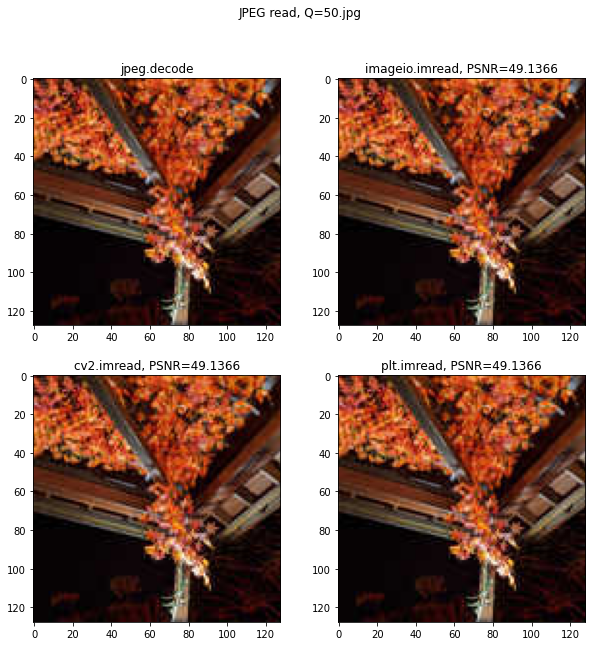

In [19]:
imageioRead_img = imageio.imread(image_path)
cv2Read_img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
pltRead_img = plt.imread(image_path)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("JPEG read, Q={}".format(Quality))
axs[0, 0].imshow(jpeg.decoded_image)
axs[0, 0].set_title("jpeg.decode")
axs[0, 1].imshow(imageioRead_img)
axs[0, 1].set_title("imageio.imread, PSNR={:.4f}".format(psnr(jpeg.decoded_image, imageioRead_img)))
axs[1, 0].imshow(cv2Read_img)
axs[1, 0].set_title("cv2.imread, PSNR={:.4f}".format(psnr(jpeg.decoded_image, cv2Read_img)))
axs[1, 1].imshow(pltRead_img)
axs[1, 1].set_title("plt.imread, PSNR={:.4f}".format(psnr(jpeg.decoded_image, pltRead_img)))

In [ ]:
test_image = imageio.imread(image_path)
height, width = test_image.shape[:2]
N = 8

for i in range(0, height, N):


# [SOI] Start of Image
# [App0] Application Default Header
[readFully] read bits:b'\x00\x10', length:2
[readFully] read bits:b'JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00', length:14
# [DQT] Quantization Table
[readFully] read bits:b'\x00C', length:2
[readFully] read bits:b'\x00\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01', length:65
## DQT length: 65
(0, array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))
# [DQT] Quantization Table
[readFully] read bits:b'\x00C', length:2
[readFully] read bits:b'\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01

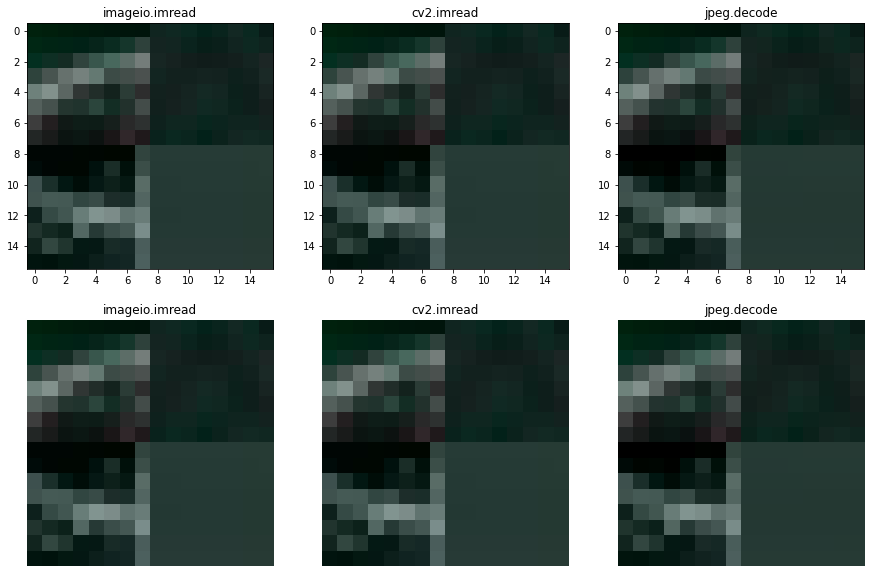

In [12]:
try:
    jpeg = JPEG(image_path)
    jpeg.decode()
except:
    pass

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].imshow(imageio.imread(image_path))
axs[0, 0].set_title("imageio.imread")
axs[0, 1].imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
axs[0, 1].set_title("cv2.imread")
axs[0, 2].imshow(jpeg.decoded_image)
axs[0, 2].set_title("jpeg.decode")

axs[1, 0].imshow(imageio.imread(image_path))
axs[1, 0].set_title("imageio.imread")
axs[1, 0].axis('off')
axs[1, 1].imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
axs[1, 1].set_title("cv2.imread")
axs[1, 1].axis('off')
axs[1, 2].imshow(jpeg.decoded_image)
axs[1, 2].set_title("jpeg.decode")
axs[1, 2].axis('off')
plt.show()